# m6A peaks and AD GWAS signals

- Data: we have m6A peaks (bed-file like) from different tissues, as well as a version merging all tissues. We also have multiple AD GWAS summary stats from different AD studies where we know the z-score for each variant we analyze, as well as if a variant is in 95% CS from fine-mapping.


## Overall
In this notebook, I aim to map m6A peaks to our finemapped AD variants to explore potential enrichment of m6A peaks. The steps are as follows:

1.	Organize m6A peak data, including:
- Conversion from hg19 to hg38 (not shown in this notebook)
- Check m6A peak sizes and downsize those larger than 1kb
- Annotate each peak with a possible associated gene
2.	Load AD finemapped data and Bellenguez sumstats to use as background.
3.	Map m6A peaks to AD finemapped and non-AD finemapped data.
4.	Perform enrichment analysis based on different contexts in Step 3.
5.	Compare whether this enrichment is brain-specific by examining the number of regions with or without AD variants in brain tissue compared to other tissues.

all GWAS analysis are focusing on Bellenguze in notebook

In [14]:
library(tidyverse)
library(data.table)
library(bedtoolsr)
library(GenomicRanges)


## Organize m6A data

combine m6A region file from all contexts together

In [4]:
m6a = data.frame()
for(file_name in list.files('~/data/m6A/Liu2020_m6A/', 'bed$',full.names = T)){
    m6a_tmp <- fread(file_name) %>% mutate(V1 = paste0('chr', V1), 
                                           hg38_ID = paste(V1,V2,V3, sep = ":"), 
                                           context = basename(file_name) %>% gsub('.bed','',.) %>% gsub('m6A_adult_','',.))
    m6a <- rbind(m6a, m6a_tmp)
}

### Check the size of m6A peaks. If the peak is > 1 Kb, take the center and extend 500 bp on each side.

In [7]:
summary(m6a$distance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     94     145     175     186     241     298 

In [6]:
m6a <- m6a %>% mutate(distance = V3-V2, 
               center = as.integer((V2+V3)/2),
               start = ifelse(distance <= 1000, V2, center - 500), 
               end = ifelse(distance <= 1000, V3, center + 500)) 
m6a %>% fwrite(., '~/data/m6A/Liu2020_m6A/m6A_adult_hg19Tohg38.all.modifyregion.bed.gz', sep = '\t')

The maxium size of m6A peaks is 298

Add gene information into each peak. 
For the peak region we can keep every gene overlapped with it , and for the regions not covered with any gene body we pick the one with nearest TSS to center of m6A region

In [10]:
gene_region <- fread('~/data/ref_data_Ru/gene_region.tsv')

gene_region <- gene_region %>%
  mutate(gene_name = str_extract(V9, 'gene_name.*?;'), 
         gene_name = str_replace_all(gene_name, 'gene_name\\s*""?|""|;', ""),
        TSS = ifelse(V7 == "+", V4, V5))

In [11]:
# we only kept protein coding gene here
pro_gene_region <- gene_region %>% filter(str_detect(V9, "protein_coding")) 

colnames(pro_gene_region)[1] <- 'V1'
pro_gene_region %>% dim


[1] 19933    12

In [12]:
m6a %>% dim
m6a %>% head

[1] 48642     9

V1,V2,V3,hg38_ID,context,distance,center,start,end
<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
chr1,267973,268220,chr1:267973:268220,cerebellum,247,268096,267973,268220
chr1,348024,348263,chr1:348024:348263,cerebellum,239,348143,348024,348263
chr1,356666,356887,chr1:356666:356887,cerebellum,221,356776,356666,356887
chr1,380695,380988,chr1:380695:380988,cerebellum,293,380841,380695,380988
chr1,487347,487497,chr1:487347:487497,cerebellum,150,487422,487347,487497
chr1,491147,491366,chr1:491147:491366,cerebellum,219,491256,491147,491366


### Overlap the m6A peaks and gene region annotation file

In [15]:
# Load necessary libraries

# Convert m6a peaks data and gene region data (pro_gene_region) to GRanges objects
m6a_gr <- GRanges(
  seqnames = m6a$V1,
  ranges = IRanges(start = m6a$start, end = m6a$end)
)

gene_gr <- GRanges(
  seqnames = pro_gene_region$V1,
  ranges = IRanges(start = pro_gene_region$V4, end = pro_gene_region$V5),
  gene_id = pro_gene_region$gene,
  gene_name = pro_gene_region$gene_name
)

For the peak region we can keep every gene overlapped with it 

In [16]:
# Find overlaps between m6a data and gene regions
overlaps <- findOverlaps(m6a_gr, gene_gr)

# Extract overlapping rows and annotate with gene information
m6a_with_gene <- m6a[queryHits(overlaps), ]
m6a_with_gene$gene_id <- pro_gene_region$gene[subjectHits(overlaps)]
m6a_with_gene$gene_name <- pro_gene_region$gene_name[subjectHits(overlaps)]

# For non-overlapping rows, find the nearest TSS
non_overlapping_indices <- setdiff(seq_len(nrow(m6a)), queryHits(overlaps))
m6a_no_gene <- m6a[non_overlapping_indices, ]

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


for the regions not covered with any gene body we pick the one with nearest TSS to center of m6A region

In [17]:
# Convert non-overlapping data to GRanges object using the center column
m6a_center_gr <- GRanges(
  seqnames = m6a_no_gene$V1,
  ranges = IRanges(start = m6a_no_gene$center, end = m6a_no_gene$center),  # Use the center column
  strand = m6a_no_gene$strand
)

# Create a GRanges object for gene data using the TSS as the start and end coordinates
gene_tss_gr <- GRanges(
  seqnames = pro_gene_region$V1,
  ranges = IRanges(start = pro_gene_region$TSS, end = pro_gene_region$TSS),  # TSS is used for both start and end
  strand = pro_gene_region$V7,
  gene_id = pro_gene_region$gene,
  gene_name = pro_gene_region$gene_name
)

# Find the nearest TSS for m6A peaks using the center
nearest_tss_indices <- nearest(m6a_center_gr, gene_tss_gr)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


combine above together

In [18]:
# Add nearest gene info to non-overlapping peaks
m6a_no_gene$gene_id <- gene_tss_gr$gene_id[nearest_tss_indices]
m6a_no_gene$gene_name <- gene_tss_gr$gene_name[nearest_tss_indices]

# Combine overlapping and non-overlapping data
m6a_gene_anno <- bind_rows(m6a_with_gene, m6a_no_gene)

# Check dimensions and preview data
m6a_no_gene %>% dim()
m6a_gene_anno %>% head()

[1] 13816    11

V1,V2,V3,hg38_ID,context,distance,center,start,end,gene_id,gene_name
<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
chr1,923934,924208,chr1:923934:924208,cerebellum,274,924071,923934,924208,ENSG00000187634,SAMD11
chr1,924961,925108,chr1:924961:925108,cerebellum,147,925034,924961,925108,ENSG00000187634,SAMD11
chr1,1055050,1055197,chr1:1055050:1055197,cerebellum,147,1055123,1055050,1055197,ENSG00000188157,AGRN
chr1,1093064,1093230,chr1:1093064:1093230,cerebellum,166,1093147,1093064,1093230,ENSG00000131591,C1orf159
chr1,1217379,1217565,chr1:1217379:1217565,cerebellum,186,1217472,1217379,1217565,ENSG00000078808,SDF4
chr1,1228913,1229062,chr1:1228913:1229062,cerebellum,149,1228987,1228913,1229062,ENSG00000078808,SDF4


In [19]:
1 - (m6a_no_gene %>% distinct(hg38_ID, context) %>% nrow) / (m6a_gene_anno %>% distinct(hg38_ID, context) %>% nrow)

[1] 0.7159656

 >71% peaks can be overlapped with gene body

## Load AD GWAS finemapping data
We focused on `AD_Bellenguez_2022` data and the variants in `cs_coverage_0.95_min_corr`

In [30]:
gwas <- fread('/mnt/vast/hpc/csg/rf2872/Work/Multivariate/GWAS_finemapping_Apr9/GWAS_finemapping_Apr9.union_export.tsv.gz')

gwas %>% dim
gwas <- gwas %>% 
        # filter(study == 'AD_Bellenguez_2022') %>% 
        mutate(chr = str_split(variant_id, ":", simplify = T) %>% .[,1] %>% paste0("chr",.),
                pos = str_split(variant_id, ":", simplify = T) %>% .[,2] %>% as.numeric) %>% filter(cs_coverage_0.95_min_corr > 0)
gwas %>% head(n = 2)
gwas %>% dim

[1] 66479    15

variant_id,z,pip,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,cs_coverage_0.95_min_corr,cs_coverage_0.7_min_corr,cs_coverage_0.5_min_corr,cs_coverage_0.95_attainable,cs_coverage_0.7_attainable,cs_coverage_0.5_attainable,study,method,block,chr,pos
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
10:11676714:A:G,6.975610,0.97921653,1,1,1,1,1,1,1,1,1,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr10_10500888_12817813,chr10,11676714
10:11672508:C:T,5.323441,0.03323309,1,0,0,1,0,0,1,0,0,AD_Jansen_2021,RSS_QC_RAISS_imputed,chr10_10500888_12817813,chr10,11672508


[1] 5749   17

## Map m6A peaks to AD finemapped variants

In [44]:
m6a_gene_anno_bed <- m6a_gene_anno[, c("V1", "start", "end", "hg38_ID", "context", "gene_id", "gene_name")]
gwas_bed <- gwas[, .(chr, start_variant = as.integer(pos), end_variant = as.integer(pos), variant_id,z,pip,cs_coverage_0.95_min_corr,block, study)]

m6a_gene_bed_ad <- bt.intersect(a = m6a_gene_anno_bed, b = gwas_bed, wa = T, wb = T) 

In [45]:
colnames(m6a_gene_bed_ad) <- c("chrom", "start", "end", "hg38_ID", "context", "gene_id", "gene_name", colnames(gwas_bed))
m6a_gene_bed_ad %>% dim
m6a_gene_bed_ad %>% head

[1] 53 16

,chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,chr12,113296387,113296637,chr12:113296387:113296637,cerebellum,ENSG00000186815,TPCN1,chr12,113296542,113296542,12:113296542:G:A,4.59375,0.0066225411,1,chr12_112825713_115165608,AD_Bellenguez_2022
2,chr12,113299621,113299844,chr12:113299621:113299844,cerebellum,ENSG00000089060,SLC8B1,chr12,113299825,113299825,12:113299825:G:A,4.60000,0.0068061377,1,chr12_112825713_115165608,AD_Bellenguez_2022
3,chr17,45656494,45656749,chr17:45656494:45656749,cerebellum,ENSG00000263715,LINC02210-CRHR1,chr17,45656617,45656617,17:45656617:G:A,-5.52623,0.0002241048,1,chr17_45383525_50162864,AD_Bellenguez_GRACE_2022
4,chr17,45832590,45832823,chr17:45832590:45832823,cerebellum,ENSG00000263715,LINC02210-CRHR1,chr17,45832722,45832722,17:45832722:G:A,-5.65945,0.0004594405,1,chr17_45383525_50162864,AD_Bellenguez_GRACE_2022
5,chr17,45832590,45832823,chr17:45832590:45832823,cerebellum,ENSG00000263715,LINC02210-CRHR1,chr17,45832817,45832817,17:45832817:G:A,-5.61824,0.0003672812,1,chr17_45383525_50162864,AD_Bellenguez_GRACE_2022
6,chr17,45832590,45832823,chr17:45832590:45832823,cerebellum,ENSG00000120088,CRHR1,chr17,45832722,45832722,17:45832722:G:A,-5.65945,0.0004594405,1,chr17_45383525_50162864,AD_Bellenguez_GRACE_2022


The reginos numbers can have AD signals in each context are like below

In [46]:
m6a_gene_bed_ad %>% distinct(variant_id,context,hg38_ID, .keep_all = T) %>% pull(study) %>% table

.
                     AD_Bellenguez_2022                AD_Bellenguez_GRACE_2022 
                                      4                                      33 
                  AD_Kunkle_Stage1_2019       AD_Wightman_Excluding23andMe_2021 
                                      1                                       3 
AD_Wightman_ExcludingUKBand23andME_2021 
                                      1 

In [47]:
m6a_gene_bed_ad %>% filter(study == 'AD_Bellenguez_GRACE_2022') %>% pull(block) %>% table

.
chr17_45383525_50162864 chr19_42346101_44935906 
                     39                       1 

a lot of peaks overlapped with AD_Bellenguez_GRACE_2022 due to a big and complex block in chr17

In [49]:
fwrite(m6a_gene_bed_ad, "m6a_adult_all_ADGWAS_cs95_mincorr_1kb.overlap.tsv", sep = '\t')

In [50]:
m6a_gene_bed_ad <- m6a_gene_bed_ad %>% filter(study == 'AD_Bellenguez_2022')

In [51]:
fwrite(m6a_gene_bed_ad, "m6a_adult_AD_Bellenguez_2022_cs95_mincorr_1kb.overlap.tsv", sep = '\t')

## Results for the comparison of annotated m6A peaks

### Figure 1: The consistency among different context/tissue
Define AD variants as variants in 95% CS from any AD GWAS data, we annotate these variants to see how many are m6A peaks. We see that brain m6A annotates more variants than other data-sets. Notice that this is variant level summary not CS level --- you can imagine limitations summarizing it this way, and how this can be improved to loci level summary if needed. I did not push it because I dont think we will use the UpsetR plot anyways, and I will get loci level information in the FET section i suggested.

cerebellum   cerebrum 
         2          2

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


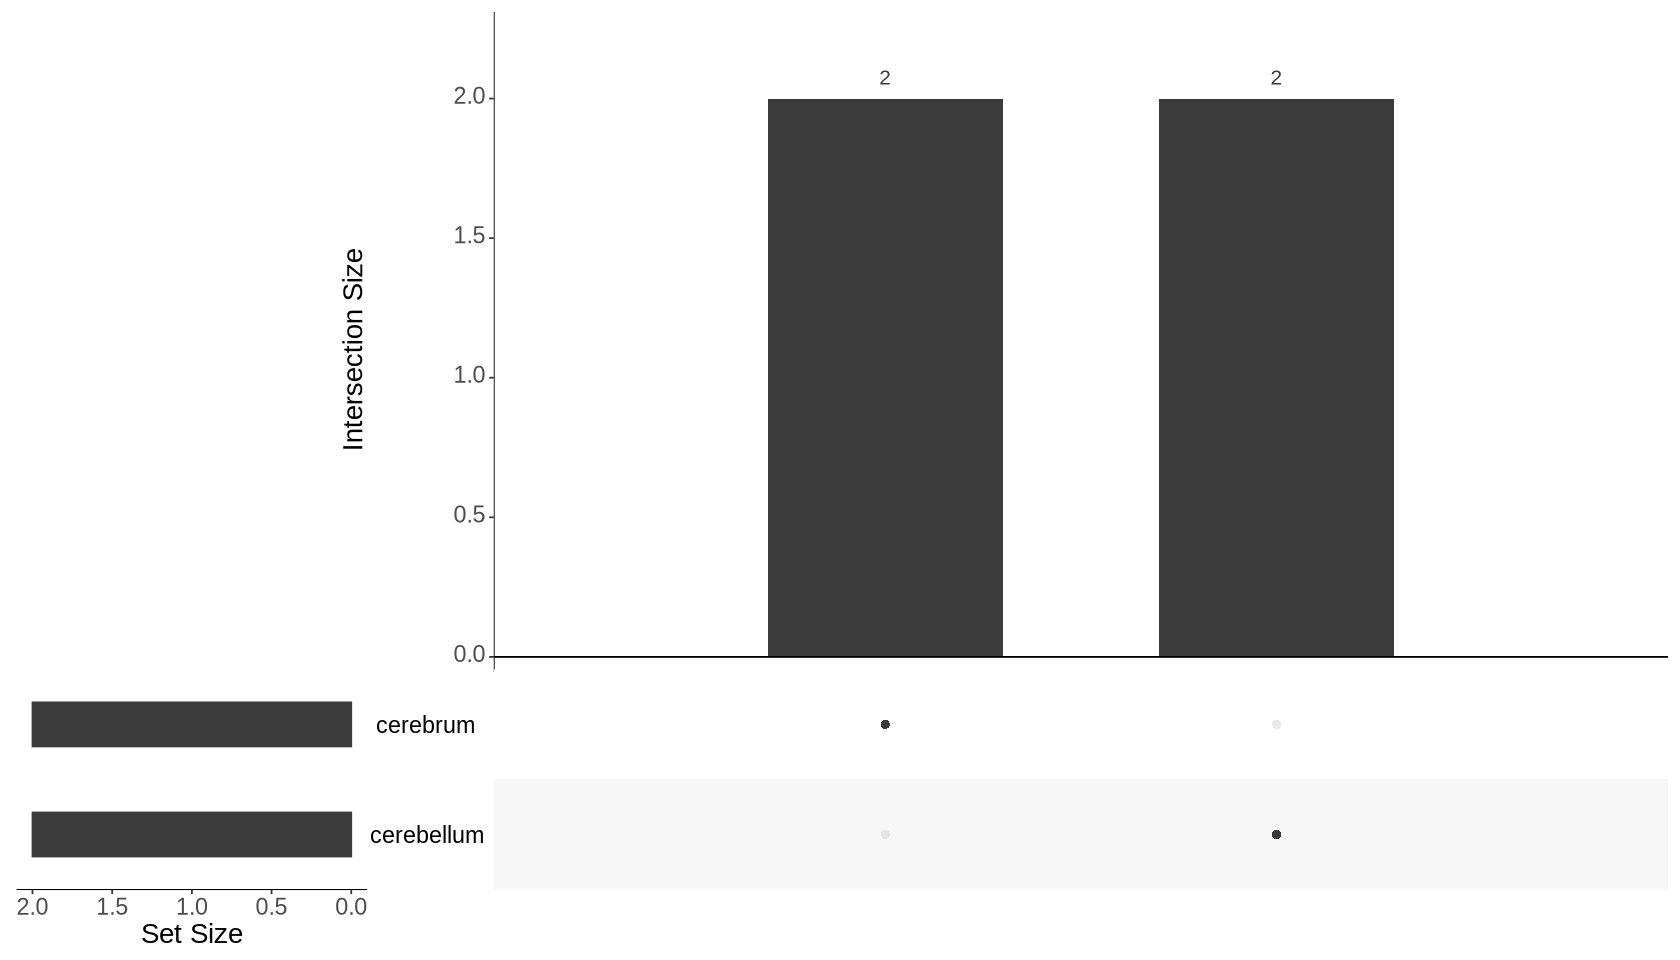

In [52]:
library(UpSetR)
library(tidyr)
library(dplyr)

options(repr.plot.width=14, repr.plot.height=8)
upset_data <- m6a_gene_bed_ad %>%
  select(variant_id, context) %>%
  distinct() %>%
  mutate(present = 1) %>%
  spread(key = context, value = present, fill = 0)
upset_data[,-1]%>% colSums
# Plot the UpSet plot to show how many variants are shared by contexts
upset(upset_data, sets = colnames(upset_data)[-1], order.by = "freq", text.scale = 2)

### Figure 2: Summarize the proportion of AD risk variants covered by peaks for each context and chromosome
Given a CS contain m6A peaks, we want to see what's the proportion of variants in the CS are m6A peaks. It's like how "pure" or "enriched" a CS is in terms of m6A modification. The goal here is to rule out if we have a very large CS with just one or two variants being m6A sites. And also to see if the overlap is not cluttered on a certain chromosome with large CS --- these are not clear from upsetR plot. Since we condition on CS containing m6A peak this is a relative metric and explains why brain has move CS+m6A overlaps than kidney but within those that are overlap, they behave similar. As I said I think this figure is more of a diagnosis although it does complement Figure 1 to further suggest that brain is interesting.

In [53]:
# Create a contingency table for intersected_data by context and chr
m6a_gene_bed_ad_table <- table(m6a_gene_bed_ad$context, m6a_gene_bed_ad$chrom)

# Create a table of gwas_bed counts by chromosome
gwas_chr_table <- table(gwas_bed$chr)

# Subset gwas_chr_table for chromosomes in intersected_table and repeat rows to match contexts
gwas_chr_counts <- gwas_chr_table[match(colnames(m6a_gene_bed_ad_table), names(gwas_chr_table))]

# Create a matrix where each row corresponds to a context and contains the chr counts from gwas_bed
gwas_chr_matrix <- matrix(gwas_chr_counts, nrow = nrow(m6a_gene_bed_ad_table), ncol = length(gwas_chr_counts), byrow = TRUE)

# Normalize the intersected_table by the corresponding gwas_bed counts
normalized_table <- m6a_gene_bed_ad_table / gwas_chr_matrix


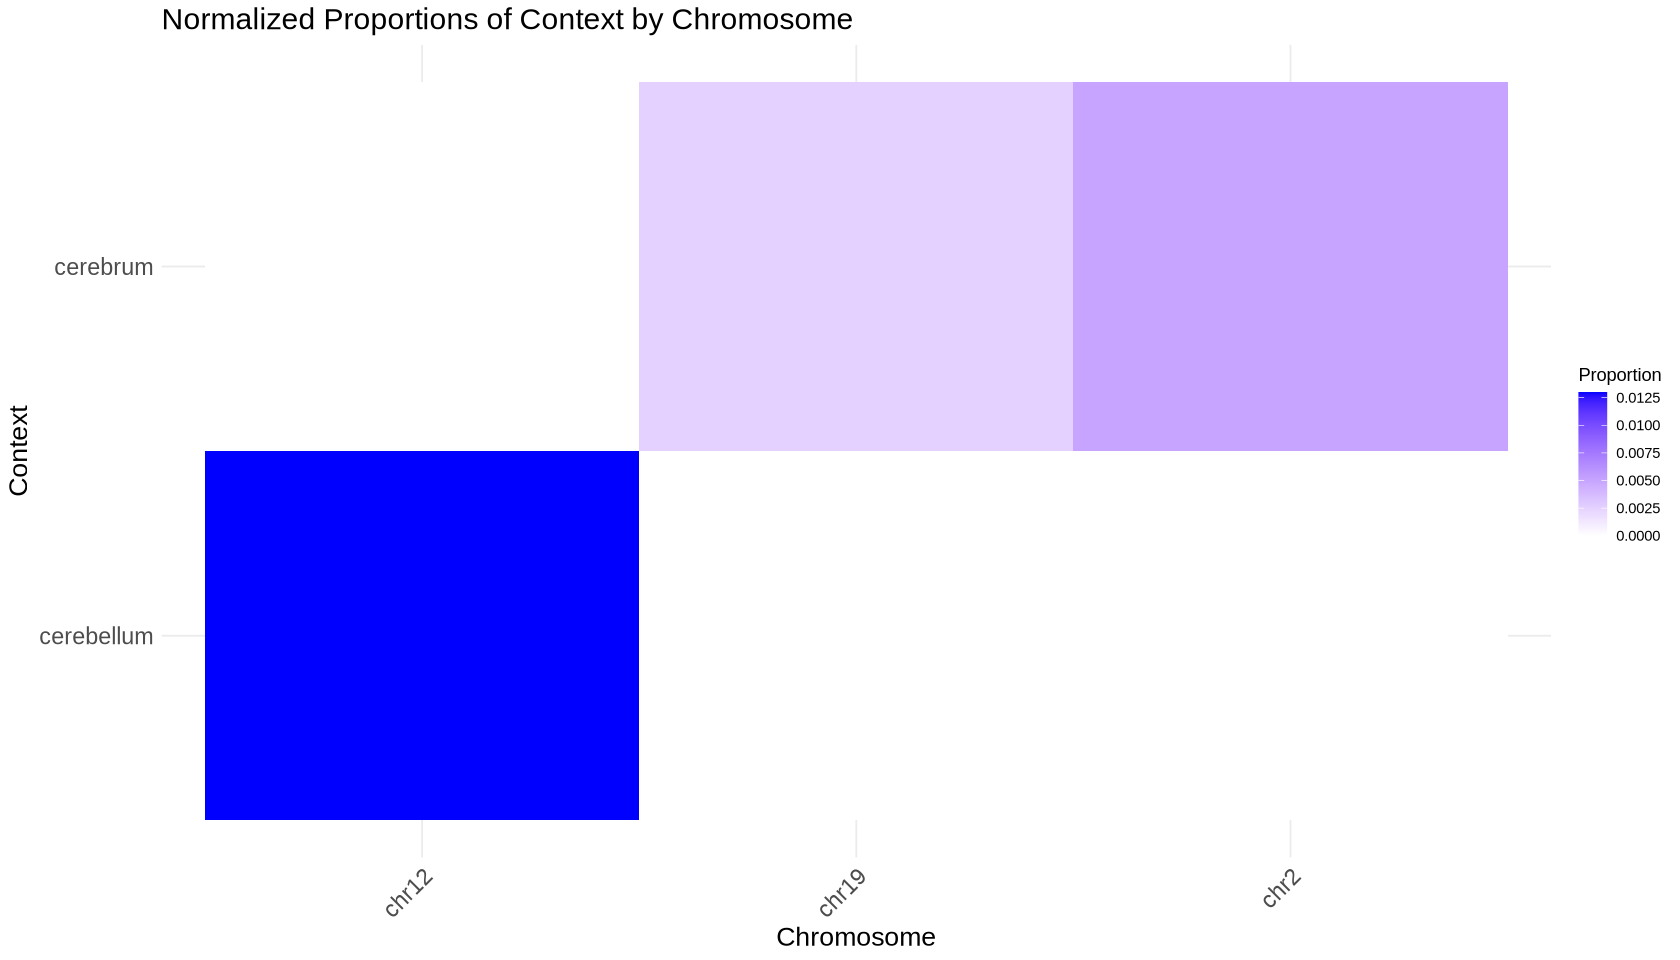

In [54]:
# Convert normalized_table to a data frame
normalized_df <- as.data.frame(as.table(normalized_table))

# Rename columns for clarity
colnames(normalized_df) <- c("Context", "Chromosome", "Proportion")
library(ggplot2)

# Plot the normalized table as a heatmap
ggplot(normalized_df, aes(x = Chromosome, y = Context, fill = Proportion)) +
  geom_tile() +   # Use tiles for the heatmap
  scale_fill_gradient(low = "white", high = "blue") +  # Customize colors
  labs(title = "Normalized Proportions of Context by Chromosome",
       x = "Chromosome", 
       y = "Context",
       fill = "Proportion") +
  theme_minimal() +
  theme(  axis.text.x = element_text(angle = 45, hjust = 1, size = 14),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 14),  # Increase font size for y-axis labels
    axis.title.x = element_text(size = 16),  # Increase font size for x-axis title
    axis.title.y = element_text(size = 16),  # Increase font size for y-axis title
    plot.title = element_text(size = 18)  # Increase font size for plot title
  ) 

## AD enrichment analysis 

fisher test with 1. m6A and AD loci, 2. m6a and not AD loci, 3. not m6a and AD loci, 4. not m6a and not AD loci

m6a_gene_bed_ad is the peak regions has AD variants in them 

In [ ]:
m6a_gene_bed_ad

### load GWAS sumstats to get all GWAS variants 

In [ ]:
all_gwas <- fread('/mnt/vast/hpc/csg/hs3393/RSS_QC/GWAS_finemapping_Apr9/RSS_QC_RAISS_imputed_concatenate_result/AD_Bellenguez_2022_RSS_QC_RAISS_imputed.tsv.gz')

In [ ]:
# extract the GWAS table without AD loci
non_ad_df <- all_gwas %>% filter(!(variant_id %in% gwas[gwas$study =='AD_Bellenguez_2022',]$variant_id))%>% 
            mutate(chr = str_split(variant_id, ":", simplify = T) %>% .[,1] %>% paste0("chr",.),
                pos = str_split(variant_id, ":", simplify = T) %>% .[,2] %>% as.numeric) 

### map the m6a region to non-AD GWAS table

In [ ]:
m6a_gene_anno_bed <- m6a_gene_anno[, c("V1", "start", "end", "hg38_ID", "context", "gene_id", "gene_name")]
non_adgwas_bed <- non_ad_df[, .(chr, start_variant = as.integer(pos), end_variant = as.integer(pos), variant_id)]

m6a_non_gene_bed_ad <- bt.intersect(a = m6a_gene_anno_bed, b = non_adgwas_bed, wa = T, wb = T) 

In [ ]:
colnames(m6a_non_gene_bed_ad) <- c("chrom", "start", "end", "hg38_ID", "context", "gene_id", "gene_name", colnames(non_adgwas_bed))
m6a_non_gene_bed_ad %>% head

### Enrichment analysis with fisher test
To generate 2x2 table:    
- ad_m6a: The number of variants within both AD loci and are m6A sites.
- ad_non_m6a: The number of variants within AD loci but not m6A sites.
- m6a_non_ad: The number of variants outside of AD loci but are m6A sites.
- non_m6a_non_ad: The number variants outside of AD loci also not m6A sites.
    
The first two categories can be calculated by finding the intersection between the m6A regions and the AD GWAS loci. The latter two categories can be calculated by finding the intersection between the m6A regions and the non-AD GWAS loci.

`intersected_data` from above analysis is the intersected table for m6A peak regions and AD GWAS loci table

`intersected_data_non_ad` here is the intersected table for m6A peak regions and non-AD GWAS loci table


The FET section: the table is focused on Bellenguez et al 2022 and is on variant level. Although I eyeballed 11 CS (we can get an accurate number) and I  know that Bellenguez has maybe 70 CS fine-mapped. So 11 out of 70 CS contain some m6A peaks. The test is still on variants though because I dont know how to make the test on CS ..

In [ ]:
perform_fisher_test <- function(adgwas, all_gwas, m6a_ad, m6a_not_ad, test_context = NULL, greater = FALSE) {
  # Define the total number of AD variants
  ad <- length(adgwas[adgwas$study == 'AD_Bellenguez_2022',]$variant_id %>% unique())
  
  # Number of AD loci in m6A regions
  ad_m6a_df <- m6a_ad 
  if(!is.null(test_context)) ad_m6a_df <- ad_m6a_df %>% filter(context == test_context)
  ad_m6a <- length(ad_m6a_df$variant_id %>% unique())
  
  # Number of AD loci outside m6A regions
  ad_non_m6a <- ad - ad_m6a
  
  # Total number of non-AD variants from GWAS concatenate sumstats
  non_ad <- length(all_gwas$variant_id %>% unique()) - ad
  
  # Number of non-AD loci in m6A regions
  m6a_non_ad_df <- m6a_not_ad 
  if(!is.null(test_context)) m6a_non_ad_df <- m6a_non_ad_df %>% filter(context == test_context)
  m6a_non_ad <- length(m6a_non_ad_df$variant_id %>% unique())
  
  # Number of non-AD loci outside m6A regions
  non_m6a_non_ad <- non_ad - m6a_non_ad
  
  # Create the contingency table
  contingency_table <- matrix(c(ad_m6a, ad_non_m6a, m6a_non_ad, non_m6a_non_ad),
                              nrow = 2,
                              byrow = TRUE,
                              dimnames = list("AD" = c("AD", "not_AD"),
                                              "m6A" = c("m6A", "not_m6A")))
  

  # Perform Fisher's Exact Test
  if(greater) fisher_test_result <- fisher.test(contingency_table, alternative = "greater") else fisher_test_result <- fisher.test(contingency_table)

  return(list(data = contingency_table, res = fisher_test_result))
}


In [ ]:
# The number of variants within both AD loci and are m6A sites in different contexts
m6a_gene_bed_ad %>% distinct(context, variant_id, .keep_all = TRUE) %>% pull(context) %>% table

In [ ]:
# The number of variants within both non-AD loci and are m6A sites in different contexts
m6a_non_gene_bed_ad %>% distinct(context, variant_id, .keep_all = TRUE) %>% pull(context) %>% table

Just show the details for `merged` and `Brian` here

In [ ]:
# Two-sided test
perform_fisher_test(adgwas = gwas, all_gwas = all_gwas, m6a_ad = m6a_gene_bed_ad, m6a_not_ad = m6a_non_gene_bed_ad) 

for other contexts, just show the pvalue for them ( two-sided)

In [ ]:
# contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
# for(test_context in contexts){
#     message(test_context,":",perform_fisher_test(adgwas = gwas, all_gwas = all_gwas, m6a_ad = m6a_gene_bed_ad, m6a_not_ad = m6a_non_gene_bed_ad, test_context = test_context)$res$p.value)
# }

In most contexts, there is an enrichment of AD loci in m6A regions, which may be inflated due to the non-independence of variants in LD?

## compare brain m6A peaks vs. m6A peaks in all other tissues
set A = brain specific, set B = both brain and other tissues, set C = other tissues but not brains. 


The test would be  1) number of "brain m6A" overlapping with Bellenguez 2022 AD CS  (AD CS hereafter) 2) number of "brain m6A" non-overlapping with AD CS, 3) number of "non-brain m6A" overlapping with AD CS , 4) number of "non-brain m6A" non-overlapping with AD CS.

when we talk about the overlap between peak regions here, if we only focus on the exactly region: same start and end. Then brain and other tissue do not have overlap. 

In [ ]:
library(VennDiagram)
library(dplyr)

brain <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_Brain') %>%
  pull(hg38_ID)

other <- m6a_gene_bed_ad %>%
  filter(context != 'GSE114150_Brain', context != 'GSE114150_merged') %>%
  pull(hg38_ID)

merged <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_merged') %>%
  pull(hg38_ID)

venn_data <- list(
  "Brain" = brain,
  "Other Tissues" = other,
  "Merged" = merged
)

venn.plot <- venn.diagram(
  x = venn_data,
  filename = NULL,  
  fill = c("#66c2a5", "#fc8d62", "#8da0cb"),  # 
  alpha = 0.6,  # 
  cex = 2,  # 
  fontface = "bold",  # 
  fontfamily = "sans",  # 
  cat.col = c("#66c2a5", "#fc8d62", "#8da0cb"),  # 
  cat.cex = 1.8,  # 
  cat.fontface = "bold",  # 
  cat.pos = c(-20, 20, 20),  # 
  cat.dist = c(0.05, 0.05, 0.05),  # 
  margin = 0.05,  # 
  lwd = 2,  # 
  lty = "solid",  # 
  col = "black"  # 
)

grid.draw(venn.plot)

If we accept overlapping regions, meaning that regions with different start and end coordinates (e.g., chr1:1-100 and chr1:20-120) can be considered the same, then almost all brain peaks are covered by peaks from other tissues. However, the numbers shown in the plot do not reflect the actual number of peaks, as they are influenced by the cutoffs applied to define peak regions. Moreover, I am unsure how to easily compare the regions based on this overlapping definition.

In [ ]:

# Helper function to convert region string into GRanges object
convert_to_granges <- function(region_list) {
  parsed_regions <- do.call(rbind, strsplit(region_list, ":"))
  gr <- GRanges(seqnames = parsed_regions[,1],
                ranges = IRanges(start = as.numeric(parsed_regions[,2]),
                                 end = as.numeric(parsed_regions[,3])))
  return(gr)
}

# Convert both region sets to GRanges
gr_brain <- convert_to_granges(brain)
gr_other <- convert_to_granges(other)

# Find overlaps between the two sets
overlaps <- findOverlaps(gr_brain, gr_other)

# Prepare counts for Venn diagram
unique_brain <- length(setdiff(seq_along(gr_brain), queryHits(overlaps)))
unique_other <- length(setdiff(seq_along(gr_other), subjectHits(overlaps)))
overlap_count <- length(queryHits(overlaps))

# Generate Venn diagram
venn.plot <- draw.pairwise.venn(area1 = unique_set1 + overlap_count,
                                area2 = unique_set2 + overlap_count,
                                cross.area = overlap_count,
                                category = c("Brain", "Other"),
                                fill = c("#66c2a5", "#fc8d62"),
                                alpha = 0.5,
                                cex = 2,
                                cat.cex = 2,
                                cat.pos = c(-20, 20))

# Display the Venn diagram
grid.draw(venn.plot)

So I am here still using the former difinition to check sets, so there is actually no overlapped region between Brain and Other tissues, which means we don't have `B` set, the compare is simply between A and C

### use all AD signals in Bellenguez data here

#### compare brain and combined other tissues

In [ ]:
brain <- m6a_gene_anno_bed %>%
  filter(context == 'GSE114150_Brain')  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_Brain') %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad
brain_ad
brain_nonad

In [ ]:
other <- m6a_gene_anno_bed %>%
  filter(context != 'GSE114150_Brain', context != 'GSE114150_merged') 
other_ad <- m6a_gene_bed_ad %>%
  filter(context != 'GSE114150_Brain', context != 'GSE114150_merged')  %>% pull(hg38_ID) %>% unique %>% length
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

In [ ]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brian", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

#### compare brain and each other tissue

In [ ]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
# contexts <- contexts[contexts!= 'GSE114150_Brain' & contexts!= 'GSE114150_merged']
contexts <- contexts[contexts!= 'GSE114150_Brain']

In [ ]:
fisher_test_result_two$estimate

In [ ]:
brain <- m6a_gene_anno_bed %>%
  filter(context == 'GSE114150_Brain')  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_Brain') %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad

for(context_target in contexts){
    other <- m6a_gene_anno_bed %>%
      filter(context == context_target) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context == context_target)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brian", context_target),
                                                "AD" = c("AD", "not_AD")))

    message("Brian AD vs ", context_target, " AD")
    
    # Print the contingency table
    print(contingency_table)
        # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
    
    # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

There is no significant difference between Brain-AD enrichment and other tissue-AD enrichment. No matter for two-sided or one-sided. 

### in 245 gene list
Then I am wondering if we can get significant difference if we use our AD genelist as background... Which is a 245 genelist from our sharing QTL-AD sharing evidence, could be a potential AD risk gene list. 

#### compare brain and combined other tissues

In [ ]:
ad_genes <- fread('/mnt/vast/hpc/csg/rf2872/data/resource_Ru/Fungen_xQTL.overlapped.gwas.min_corr_gwas95_qtl70.Apr.tsv')

In [ ]:
brain <- m6a_gene_anno_bed %>%
  filter(context == 'GSE114150_Brain', gene_id %in% ad_genes$region_id)  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_Brain', gene_id %in% ad_genes$region_id) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad
brain_ad
brain_nonad

In [ ]:
other <- m6a_gene_anno_bed %>%
  filter(context != 'GSE114150_Brain', context != 'GSE114150_merged', gene_id %in% ad_genes$region_id) 
other_ad <- m6a_gene_bed_ad %>%
  filter(context != 'GSE114150_Brain', context != 'GSE114150_merged', gene_id %in% ad_genes$region_id)  %>% pull(hg38_ID) %>% unique %>% length
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

In [ ]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brian", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

#### compare brain and each other tissue

In [ ]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
contexts <- contexts[contexts!= 'GSE114150_Brain']

In [ ]:
brain <- m6a_gene_anno_bed %>%
  filter(context == 'GSE114150_Brain', gene_id %in% ad_genes$region_id)  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_Brain', gene_id %in% ad_genes$region_id) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad

for(context_target in contexts){
    other <- m6a_gene_anno_bed %>%
      filter(context == context_target, gene_id %in% ad_genes$region_id) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context == context_target, gene_id %in% ad_genes$region_id)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brian", context_target),
                                                "AD" = c("AD", "not_AD")))

    message("Brian AD vs ", context_target, " AD")
    
    # Print the contingency table
    print(contingency_table)
        # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
    
     # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

which is even more unsignificant...

### in different chromosome
what about if we focus on different chromosome?.. If there is some chromosome can show Brain peak specificty, e.g. chr19?

#### compare brain and combined other tissues

In [ ]:
for(i in 1:22){
    chromosome = paste0('chr',i)
    message(chromosome)
    brain <- m6a_gene_anno_bed %>%
      filter(context == 'GSE114150_Brain', V1 == chromosome)  
    brain_ad <- m6a_gene_bed_ad %>%
      filter(context == 'GSE114150_Brain', chrom == chromosome) %>% pull(hg38_ID) %>% unique %>% length
    brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad
    
    other <- m6a_gene_anno_bed %>%
      filter(context != 'GSE114150_Brain', context != 'GSE114150_merged', V1 == chromosome) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context != 'GSE114150_Brain', context != 'GSE114150_merged', chrom == chromosome)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brian", "Other"),
                                                "AD" = c("AD", "not_AD")))
    
    # Perform Fisher's Exact Test
    # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
    
    # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

Nothing specific if we compare Brain vs pooled_others, may beacause of not enough peaks per chromosome

#### compare brain and each other tissue

In [ ]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
contexts <- contexts[contexts!= 'GSE114150_Brain']

In [ ]:
message('Print One-sided Fisher exact test pvalue < 0.5 only') 
message('Also printed 2x2 table since some test results have odds as Inf') 
for(i in 1:22){
    chromosome = paste0('chr',i)
    brain <- m6a_gene_anno_bed %>%
      filter(context == 'GSE114150_Brain', V1 == chromosome)  
    brain_ad <- m6a_gene_bed_ad %>%
      filter(context == 'GSE114150_Brain', chrom == chromosome) %>% pull(hg38_ID) %>% unique %>% length
    brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad

    for(context_target in contexts){
        other <- m6a_gene_anno_bed %>%
          filter(context == context_target, V1 == chromosome) 
        other_ad <- m6a_gene_bed_ad %>%
          filter(context == context_target, chrom == chromosome)  %>% pull(hg38_ID) %>% unique %>% length
        other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
        
        # Create the contingency table
        contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                    nrow = 2,
                                    byrow = TRUE,
                                    dimnames = list("Tissue" = c("Brian", context_target),
                                                    "AD" = c("AD", "not_AD")))
    
        
            # two sides
        fisher_test_result_two <- fisher.test(contingency_table)
        # one side
        fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
        
        # Print the Fisher test result
        if (fisher_test_result_one$p.value < 0.5) {
    
            message("Brian AD vs ", context_target, " AD on ", chromosome)
            print(contingency_table)
            print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
        }
    }
}

## Conclusion:
1. In most contexts within the provided data, there is AD enrichment based on Fisher’s test results;
2. However, brain tissue does not show greater specificity for AD enrichment compared to other tissues.